In [1]:
import numpy  as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense
import PIL
import tensorflow as tf
from keras.datasets import cifar10
from tensorflow import keras
from keras.models import Sequential
from keras.layers import (
    Conv2DTranspose,Reshape,BatchNormalization, SeparableConv2D, MaxPooling2D, Activation, Flatten, Dropout, Dense, Conv2D,UpSampling2D,Input
)

from PIL import Image as im
from keras.models import Model
from sklearn.model_selection import train_test_split
import cv2


In [32]:
from google.colab import files
files.upload()

{}

In [2]:
def load_data():
    (x_train, y_train), (x_test, y_test) = cifar10.load_data()
    m = x_train.shape[0]
    n = x_test.shape[0]
    width = x_train.shape[1]
    height = x_train.shape[2]
    x_train = np.reshape(x_train, (-1,width,height,3))
    x_test = np.reshape(x_test,(-1,width,height,3))
    y_train = tf.keras.utils.to_categorical(y_train)
    y_test = tf.keras.utils.to_categorical(y_test)

    x_train = x_train.astype('float32')
    x_test = x_test.astype('float32')

    x_train /= 255
    x_test /= 255

    return x_train,y_train,x_test,y_test

In [3]:
x_train,y_train,x_test,y_test = load_data()

170508288/170498071 [==============================] - 4s 0us/step


In [4]:
x_train.shape

(50000, 32, 32, 3)

In [5]:
y_train.shape

(50000, 10)

In [8]:
x_test.shape

(10000, 32, 32, 3)

In [9]:
y_test.shape

(10000, 10)

In [4]:
def add_gaussian_noise(X_imgs):
    gaussian_noise_imgs = []
    row, col, ch= X_imgs[0].shape
    # Gaussian distribution parameters
    '''mean = 0
    var = 0.9
    sigma = var ** 0.5'''
    
    for X_img in X_imgs:
        gaussian = X_img + 0.1*np.random.normal(loc = 0.0,scale = 1.0,size = (row, col, ch))
        gaussian_img = np.clip(gaussian, 0., 1.)
        '''gaussian_img = cv2.addWeighted(X_img, 0.75, 0.4 * gaussian, 0.25, 0)
        gaussian_img = np.reshape(gaussian_img,(row,col,ch))'''
        gaussian_noise_imgs.append(gaussian_img)
    gaussian_noise_imgs = np.array(gaussian_noise_imgs, dtype = np.float32)
    return gaussian_noise_imgs

In [5]:
x_train_noisy = add_gaussian_noise(x_train)
x_test_noisy = add_gaussian_noise(x_test)

In [8]:
x_train_noisy.shape

(50000, 32, 32, 3)

In [13]:
x_test_noisy.shape

(10000, 32, 32, 3)

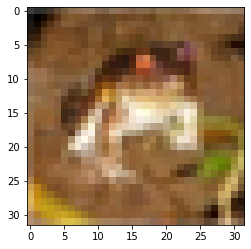

In [6]:
import PIL
from PIL import Image
img = x_train[0]
plt.imshow(img)
plt.show()


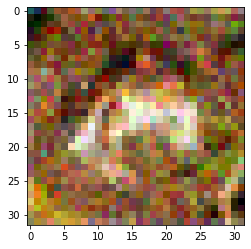

In [8]:
import PIL
from PIL import Image
img = x_train_noisy[0]
#img = np.reshape(img, (28,28))
plt.imshow(img)
plt.show()


In [6]:
def encoder(input_img):

    conv1_1 = Conv2D(128, (3, 3), activation='relu', padding='same')(input_img) 
    conv1_2 = MaxPooling2D((2,2),padding = 'same')(conv1_1)
    conv1_3 = BatchNormalization()(conv1_2)
    

    conv2_1 = Conv2D(256,kernel_size=3,padding='same',activation='relu')(conv1_3)
    conv2_2 = MaxPooling2D((2,2),padding = 'same')(conv2_1)
    conv2_3 = BatchNormalization()(conv2_2)

    #conv3_1 = Conv2D(16,kernel_size=3,padding='same',activation='relu')(conv2_3)
    #conv3_2 = MaxPooling2D((2,2),padding = 'same')(conv3_1)
    #conv3_3 = BatchNormalization()(conv3_2)
    

    #conv4 = Flatten()(conv3_2)
    #conv4 = Dense(1024)(conv4)
    return conv2_3

In [7]:
def decoder(encode):
    
    #conv5_1 = Reshape((4,4,64))(encode)
    #conv5_2 = Conv2DTranspose(32, kernel_size = 3, strides = 2,activation='relu', padding='same')(conv5_1)
    conv4_1 = Conv2D(256, (3, 3), activation='relu', padding='same')(encode)
    conv4_2 = UpSampling2D((2,2))(conv4_1)

    conv5_1 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv4_2)
    conv5_2  = UpSampling2D((2, 2))(conv5_1)

    #conv6_1 = Conv2D(16, (3, 3), activation='relu',padding = 'same')(conv5_2)
    #conv6_2 = UpSampling2D((2, 2))(conv6_1)
    decode = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(conv5_2)

    #conv6_1 = Conv2DTranspose(16, kernel_size = 3, strides = 2,activation='relu', padding='same')(conv5_2)
    #conv6_2 = BatchNormalization()(conv6_1)

    #conv7_1 = Conv2DTranspose(3, kernel_size=3, strides=2, padding='same', activation="sigmoid")(conv6_2)
   
    return decode

In [8]:
inChannel = 3
x, y = 32, 32
input_img = Input(shape = (x, y,inChannel))
autoencoder = Model(input_img, decoder(encoder(input_img)))

In [62]:
'''lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.5,
    decay_steps=10000,
    decay_rate=0.9)
opt = keras.optimizers.SGD(learning_rate=lr_schedule)
autoencoder.compile(loss="binary_crossentropy", optimizer=opt)'''

In [9]:
autoencoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 32, 32, 128)       3584      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 128)      0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 16, 16, 128)      512       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 256)       295168    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 8, 8, 256)        0     

In [10]:
train_X,valid_X,train_ground,valid_ground = train_test_split(x_train_noisy,
                                                             x_train,
                                                             test_size=0.2,
                                                             random_state=13)

In [22]:
train_X.shape

(40000, 32, 32, 3)

In [23]:
valid_X.shape

(10000, 32, 32, 3)

In [24]:
train_ground.shape

(40000, 32, 32, 3)

In [25]:
valid_ground.shape

(10000, 32, 32, 3)

In [11]:
batch_size = 64
epochs = 20

In [12]:
#opt = tf.keras.optimizers.SGD(learning_rate=0.05)
autoencoder.compile(loss='binary_crossentropy', optimizer = 'adam')

In [13]:
autoencoder_train = autoencoder.fit(train_X, train_ground, batch_size=batch_size,epochs=epochs,verbose=1,validation_data=(valid_X, valid_ground))
autoencoder.save_weights('autoencoder.h5')

Epoch 1/20
625/625 [==============================] - 1160s 2s/step - loss: 0.5657 - val_loss: 0.5622
Epoch 2/20
625/625 [==============================] - 1157s 2s/step - loss: 0.5576 - val_loss: 0.5563
Epoch 3/20
625/625 [==============================] - 1157s 2s/step - loss: 0.5560 - val_loss: 0.5615
Epoch 4/20
625/625 [==============================] - 1156s 2s/step - loss: 0.5551 - val_loss: 0.5559
Epoch 5/20
625/625 [==============================] - 1158s 2s/step - loss: 0.5545 - val_loss: 0.5566
Epoch 6/20
625/625 [==============================] - 1162s 2s/step - loss: 0.5542 - val_loss: 0.5554
Epoch 7/20
625/625 [==============================] - 1161s 2s/step - loss: 0.5540 - val_loss: 0.5553
Epoch 8/20
625/625 [==============================] - 1165s 2s/step - loss: 0.5537 - val_loss: 0.5540
Epoch 9/20
625/625 [==============================] - 1164s 2s/step - loss: 0.5536 - val_loss: 0.5551
Epoch 10/20
625/625 [==============================] - 1171s 2s/step - loss: 0.553

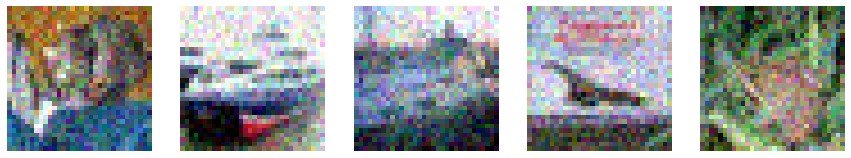

In [14]:
reconstructs = autoencoder.predict(x_test_noisy)
#reconstructs = np.reshape(reconstructs,(-1,28,28))
#x_test_noisy = np.reshape(x_test_noisy,(-1,28,28))
plt.figure(figsize=(15,12))
for i in range(5):
    plt.subplot(2,5,1+i)
    plt.imshow(x_test_noisy[i])
    plt.axis('off')
    '''plt.subplot(2,5,6+i)
    plt.imshow(reconstructs[i])
    plt.axis('off')'''
plt.show()

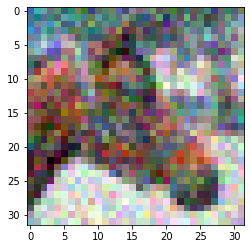

In [29]:
plt.imshow(x_test_noisy[17])

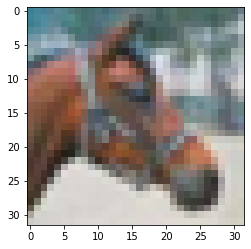

In [30]:
plt.imshow(x_test[17])

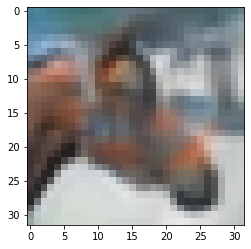

In [31]:
plt.imshow(reconstructs[17])

In [28]:
autoencoder.load_weights('autoencoder.h5')

In [30]:
autoencoder_train = autoencoder.fit(train_X, train_ground, batch_size=batch_size,epochs=10,verbose=1,validation_data=(valid_X, valid_ground))

Epoch 1/10
625/625 [==============================] - 178s 284ms/step - loss: 0.0071 - val_loss: 0.0067
Epoch 2/10
625/625 [==============================] - 167s 268ms/step - loss: 0.0071 - val_loss: 0.0068
Epoch 3/10
 51/625 [=>............................] - ETA: 2:23 - loss: 0.0070

KeyboardInterrupt: ignored